In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch import nn
import torch
from pytorch_lightning import LightningModule
from torch import nn
from torchinfo import summary
from torchvision import models

import os
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

### Data analysis

In [2]:
SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080
GRID_COLS = 2
GRID_ROWS = 2

In [3]:
# load database
df = pd.read_csv('../data_collection_phase/data/only_face.csv')
df.head()


,File Path Face Image,x,y
0,face_image_1.png,1664,624
1,face_image_2.png,1559,434
2,face_image_3.png,1163,715
3,face_image_4.png,377,862
4,face_image_5.png,750,611


1664 624


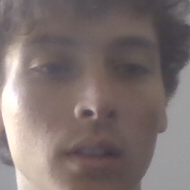

In [4]:
# show first image in df
img_path = df.iloc[0]['File Path Face Image'] # => face_image_1.png
full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
img = Image.open(full_path)
# print point I was looking
print(df.iloc[0]['x'], df.iloc[0]['y'])
img


### Make it classification of cell in screen

In [5]:
# screen is 1920x1080. We divide in 2x2 grid.
# each cell is 960x540
# we need to convert the x,y coordinates to the grid cell
df_class = df.copy()
# if x is between 0 and 960 and y is between 0 and 540, the cell is 0
# if x is between 960 and 1920 and y is between 0 and 540, the cell is 1
# if x is between 0 and 960 and y is between 540 and 1080, the cell is 2
# if x is between 960 and 1920 and y is between 540 and 1080, the cell is 3
df_class['cell'] = df_class.apply(lambda row: 0 if row['x'] < 960 and row['y'] < 540 else 1 if row['x'] >= 960 and row['y'] < 540 else 2 if row['x'] < 960 and row['y'] >= 540 else 3, axis=1)
df_class.head()


,File Path Face Image,x,y,cell
0,face_image_1.png,1664,624,3
1,face_image_2.png,1559,434,1
2,face_image_3.png,1163,715,3
3,face_image_4.png,377,862,2
4,face_image_5.png,750,611,2


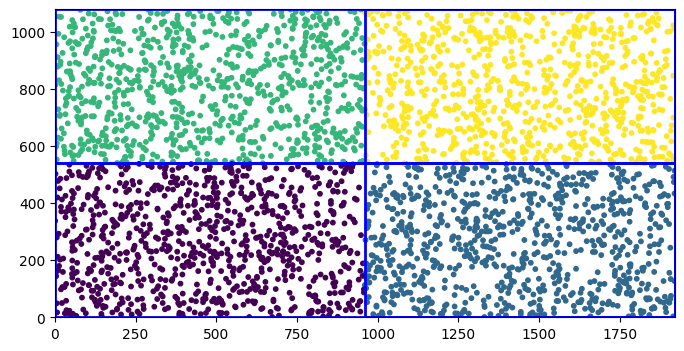

In [6]:
# plot graph simulate the screen 1920x1080
# plot the x,y coordinates in the screen
# plot the cell in the screen

# Create a 1920x1080 plot
plt.figure(figsize=(8, 4))
plt.xlim(0, 1920)
plt.ylim(0, 1080)

# draw square of the cell in the screen
plt.plot([0, 1920, 1920, 0, 0], [0, 0, 540, 540, 0], 'b-', lw=2)
plt.plot([960, 960, 1920, 1920, 960], [0, 540, 540, 0, 0], 'b-', lw=2)
plt.plot([0, 1920, 1920, 0, 0], [540, 540, 1080, 1080, 540], 'b-', lw=2)
plt.plot([960, 960, 1920, 1920, 960], [540, 1080, 1080, 540, 540], 'b-', lw=2)

# plot the x,y coordinates in the screen and if cell is 0, 1, 2, 3, plot the cell in the screen with different color
plt.scatter(df_class['x'], df_class['y'], c=df_class['cell'], label='Eye Position', s=10)

plt.show()


### Create image of both eyes toghether

In [7]:
# for each image cut the face
# the rectangle has top left corner [22,46] and bottom right corner [156,86]
# save the image in the folder /both_eyes with name of the image both_eyes_image_<n>.png (where n is the same number of the face image)

# load the image
#img_path = df.iloc[0]['File Path Face Image'] # => face_image_1.png
#full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
#img = Image.open(full_path)
#
## cut the face
#face = img.crop((22,46,156,86))
#
## save the image
#face.save(f'both_eyes/both_eyes_image_1.png')

In [8]:
# do it for all images
#for i in range(len(df)):
#    img_path = df.iloc[i]['File Path Face Image'] # => face_image_1.png
#    full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
#    img = Image.open(full_path)
#    face = img.crop((22,46,156,86))
#    face.save(f'both_eyes/both_eyes_image_{i}.png')

In [ ]:
# add all images to a copy of the database
df_both_eyes = df_class.copy()
df_both_eyes['File Path Both Eyes Image'] = df_both_eyes['File Path Face Image'].apply(lambda x: f'both_eyes/both_eyes_image_{x.split("_")[-1]}')
df_both_eyes.head()

,File Path Face Image,x,y,cell,File Path Both Eyes Image
0,face_image_1.png,1664,624,3,both_eyes/both_eyes_image_1.png
1,face_image_2.png,1559,434,1,both_eyes/both_eyes_image_2.png
2,face_image_3.png,1163,715,3,both_eyes/both_eyes_image_3.png
3,face_image_4.png,377,862,2,both_eyes/both_eyes_image_4.png
4,face_image_5.png,750,611,2,both_eyes/both_eyes_image_5.png


In [27]:
# delete last row of df_both_eyes
df_both_eyes_ = df_both_eyes[:-1]
df_both_eyes_

,File Path Face Image,x,y,cell,File Path Both Eyes Image
0,face_image_1.png,1664,624,3,both_eyes/both_eyes_image_1.png
1,face_image_2.png,1559,434,1,both_eyes/both_eyes_image_2.png
2,face_image_3.png,1163,715,3,both_eyes/both_eyes_image_3.png
3,face_image_4.png,377,862,2,both_eyes/both_eyes_image_4.png
4,face_image_5.png,750,611,2,both_eyes/both_eyes_image_5.png
...,...,...,...,...,...
3428,face_image_3430.png,1725,432,1,both_eyes/both_eyes_image_3430.png
3429,face_image_3431.png,1781,1022,3,both_eyes/both_eyes_image_3431.png
3430,face_image_3432.png,1409,791,3,both_eyes/both_eyes_image_3432.png
3431,face_image_3433.png,169,838,2,both_eyes/both_eyes_image_3433.png


### Build CNN

##### Split

In [ ]:
#all_images = df_class['File Path Face Image'].tolist() # => ['face_image_1.png', 'face_image_2.png' ...]
#all_images = [os.path.join('../data_collection_phase/data/only_face', img) for img in all_images] # add to all_images the full path
#images = [np.array(Image.open(path).resize((190, 190))) for path in all_images]
#images_array = np.array(images, dtype=np.float32) / 255.0  # Ensure dtype is float32
#
#all_cells = np.array(df_class['cell'].tolist()).reshape(-1, 1)
#
## Split train/test
#x_train, x_test, y_train, y_test = train_test_split(images_array, all_cells, test_size=0.2, random_state=42)

In [28]:
all_images = df_both_eyes_['File Path Both Eyes Image'].tolist() # => ['face_image_1.png', 'face_image_2.png' ...]
images = [np.array(Image.open(path).resize((134, 40))) for path in all_images]
images_array = np.array(images, dtype=np.float32) / 255.0  # Ensure dtype is float32

all_cells = np.array(df_both_eyes_['cell'].tolist()).reshape(-1, 1)

# Split train/test
x_train, x_test, y_train, y_test = train_test_split(images_array, all_cells, test_size=0.2, random_state=42)

In [29]:
# Dataset shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Number of unique classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

x_train shape: (2746, 40, 134, 3)
y_train shape: (2746, 1)
x_test shape: (687, 40, 134, 3)
y_test shape: (687, 1)
Number of classes: 4


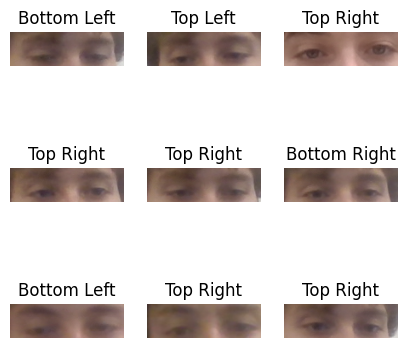

In [30]:
# Define class names for easy reference
class_names = ["Top Left", "Top Right", "Bottom Left", "Bottom Right"]

# Plot a 3x3 grid of random images from the dataset with their labels
plt.figure(figsize=(5, 5))
for i in range(9):
    index = np.random.randint(0, len(x_train))
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[index])
    plt.title(class_names[y_train[index][0]])
    plt.axis("off")
plt.show()

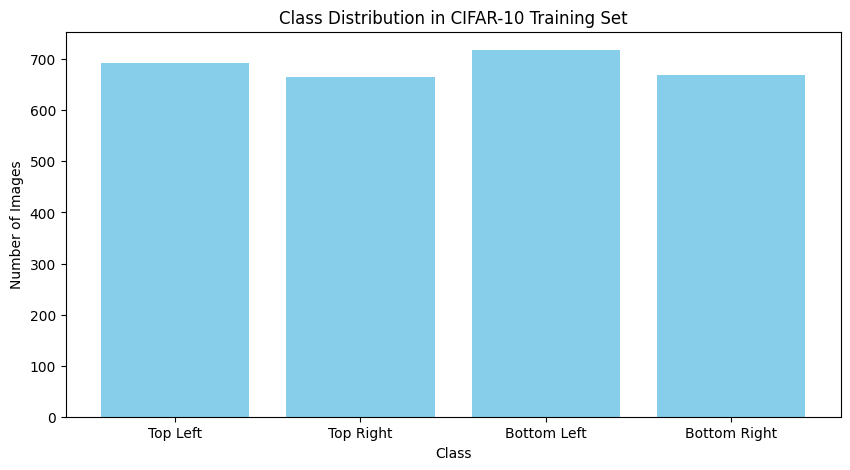

In [32]:
# Count occurrences of each class in the training set
class_counts = np.bincount(y_train.flatten())

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.title("Class Distribution in CIFAR-10 Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [33]:
# Check the minimum and maximum pixel values
print(f"Minimum pixel value: {x_train.min()}")
print(f"Maximum pixel value: {x_train.max()}")

Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [34]:
# one hot encode y_train and y_test
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [46]:
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_train sample: {y_train[2]}")

y_train shape: (2746, 4)
y_test shape: (687, 4)
y_train sample: [1. 0. 0. 0.]


#### Model

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 (without the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(40, 134, 3))

# Allow some VGG16 layers to train
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Keep last 4 layers trainable
    layer.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [59]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2669 - loss: 1.5452 - val_accuracy: 0.2314 - val_loss: 1.3911
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.2329 - loss: 1.4773 - val_accuracy: 0.2198 - val_loss: 1.3890
Epoch 3/10
 8/43 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2541 - loss: 1.4353

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy}')

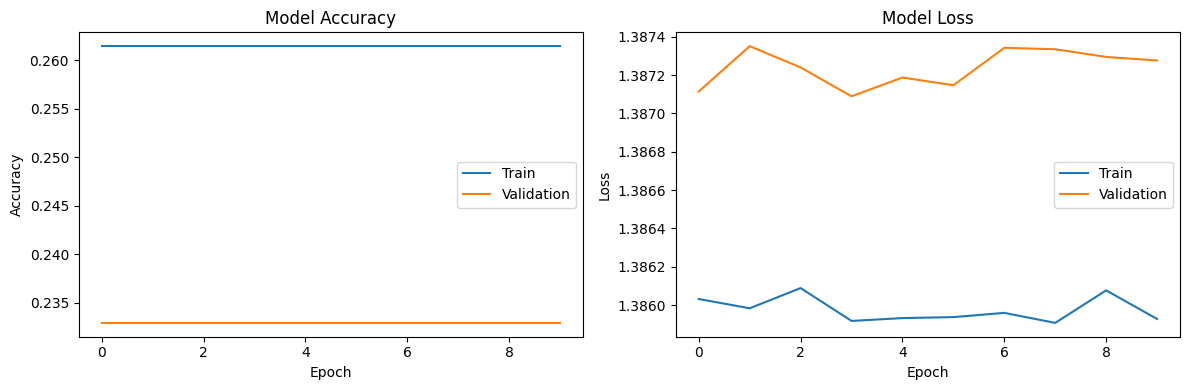

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


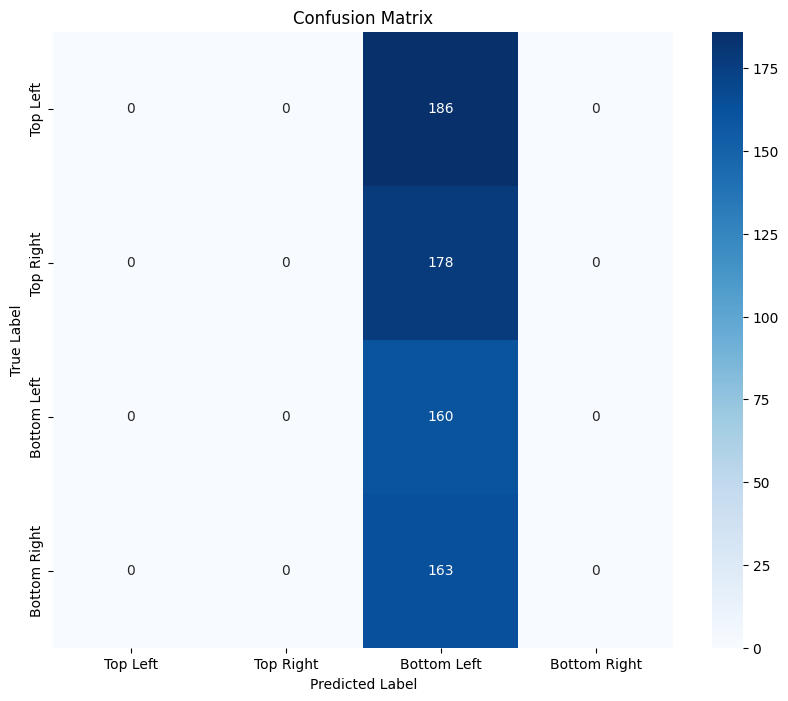

In [44]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Generate predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

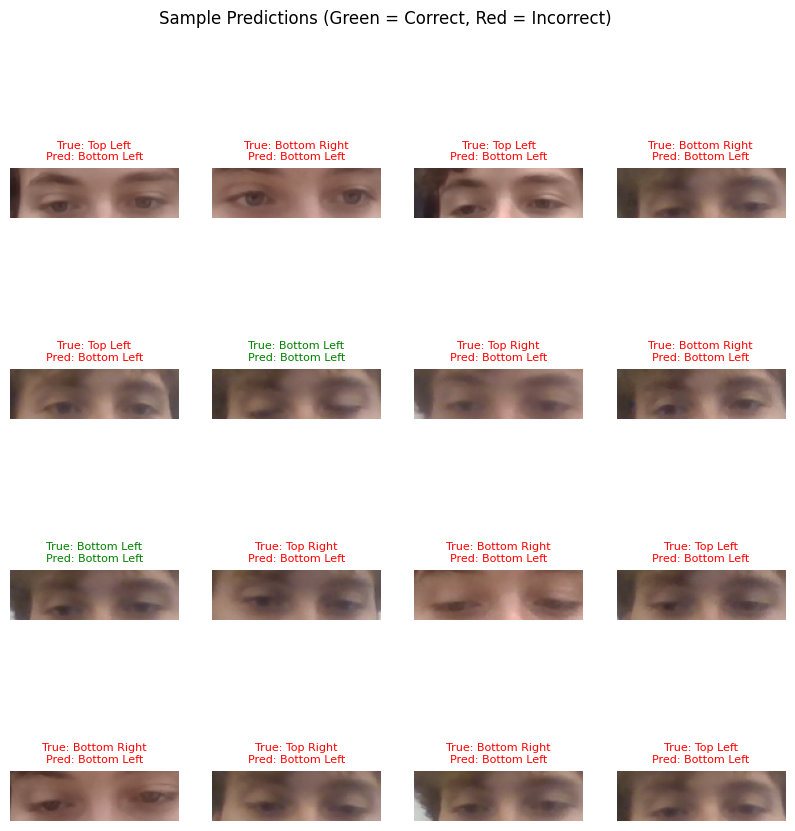

In [45]:
# Plot sample images with their predicted and true labels
plt.figure(figsize=(10, 10))
for i in range(16):
    index = np.random.randint(0, len(x_test))
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[index])
    true_label = class_names[y_true_classes[index]]
    pred_label = class_names[y_pred_classes[index]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=8)
    plt.axis("off")
plt.suptitle("Sample Predictions (Green = Correct, Red = Incorrect)")
plt.show()